In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
import math
import scipy.stats
import numpy as np
from scipy.stats import truncnorm
from scipy.stats import multivariate_normal
from matplotlib import cbook, cm
from matplotlib.colors import LightSource
from scipy.stats import norm

In [3]:
N = 10_000
s_1 = np.zeros(N)
s_2 = np.zeros(N)
sig_t = 5
A = np.array([[1, -1]])
t = np.zeros(N)
sigma_s = np.array([[100, 0], [0, 100]]) 
mu_matrix = np.array([100, 100]) 

s_1[0] = 100
s_2[0] = 100
t[0] = 20


In [180]:
def gibbs_sample(N, burn, mu_s1, var_s1, mu_s2, var_s2, y):

    # N total iterations
    # [N - burn] values are returned

    s_1 = np.zeros(N)
    s_2 = np.zeros(N)
    t = np.zeros(N)

    sigma_s = np.array([[var_s1, 0], [0, var_s2]]) 

    # print(f"sigma_s: {sigma_s}\n")

    mu_matrix = np.array([[mu_s1], [mu_s2]]) 

    # print(f"mu matrix: {mu_matrix}\n")

    s_1[0] = np.random.normal(mu_s1, np.sqrt(var_s1))
    s_2[0] = np.random.normal(mu_s2, np.sqrt(var_s2))
    
    mu_t = mu_s1 - mu_s2 # to calc mu_t before game with anterior skills
    sig_t = var_s1 + var_s2

    y = y

    # do heavy calculations before loop
    A = np.array([[1, -1]])
    sigma_st = np.linalg.inv(np.linalg.inv(sigma_s) + A.transpose()*(sig_t**(-1))*A)
    sig_s__mu_mat = np.matmul(np.linalg.inv(sigma_s),mu_matrix)
    A_t__sig_t = A.transpose()*(sig_t**(-1))
  
    for n in range(N-1):
        #print(s_1[:n+1])
        mu_t = s_1[n] - s_2[n] #calc mu_t with posterior skills
        a, b = (-mu_t)/np.sqrt(sig_t), np.inf


        if(y == 1):
            t[n+1] = truncnorm.rvs(a, b, loc= mu_t, scale = np.sqrt(sig_t), size=1)
        else:
            t[n+1] = truncnorm.rvs(-b, a, loc= mu_t, scale = np.sqrt(sig_t), size=1)



        mu_st = np.matmul(sigma_st,(sig_s__mu_mat + A_t__sig_t*t[n+1]))
        # print(mu_st,"\n")
        new_s = np.random.multivariate_normal([mu_st[0][0], mu_st[1][0]], sigma_st)
        s_1[n+1] = new_s[0]
        s_2[n+1] = new_s[1]

    return(s_1[burn:], s_2[burn:], t[burn:])

In [132]:
def gibbs_sample_v2(N, mu_s1, sig_s1, mu_s2, sig_s2, y):

    s1_samps = []
    s2_samps = []
    t_samps = []

    sig_s = np.array([[sig_s1, 0],
                      [0, sig_s2]])
    
    mu_s = np.array([mu_s1, mu_s2])

    mu_t = mu_s1 - mu_s2
    sig_t = sig_s1 + sig_s1

    A = np.array([1, -1])
    a, b = 0, np.inf

    for n in range(N):
        t_samps.append(truncnorm.rvs(a, b, loc=mu_t, scale=np.sqrt(sig_t), size=1))
        sig_st = np.linalg.inv(np.linalg.inv(sig_s) + A.transpose()*(1/sig_t)*A)
        print(sig_st)
        mu_st = np.matmul(sig_st, (np.matmul(np.linalg.inv(sig_s), mu_s) + A.transpose()*(1/sig_t)*t[n]))
        print(mu_st)
        s_samp = np.random.multivariate_normal([mu_st[0], mu_st[1]], sig_st)

        s1_samps.append(s_samp[0])
        s2_samps.append(s_samp[1])

    return(s1_samps, s2_samps)

In [181]:
iter = 10000
burn = 2000
s1, s2, t = gibbs_sample(iter, burn, 25, 25/3, 25, 25/3, 1)

# Sassuolo vs Empoli -> Sassuolo won
# 2
# Sassuolo: [33.51 -> 38.56] & [3.75 -> 2.97]
# Empoli: [20.11 -> 34.07] & [4.49 -> 3.34]

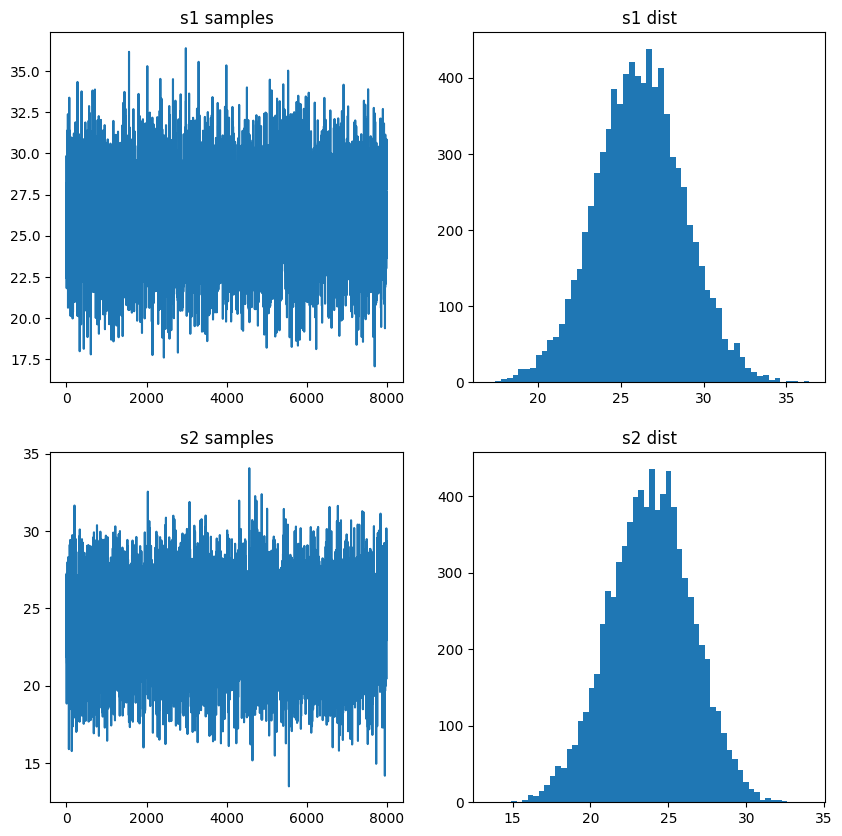

mean_s1 = 26.16185618927865, var_s1 = 7.054732548273182
mean_s2 = 23.846502084071346, var_s2 = 7.053789604697347


In [175]:


iterations_num = [i + 1 for i in range(iter-burn)]

plt.rcParams['figure.figsize'] = [10, 10]
fig, axs = plt.subplots(2, 2)

axs[0, 0].plot(iterations_num,s1)
axs[0, 0].set_title("s1 samples")
axs[0, 1].hist(s1,bins = "auto")
axs[0, 1].set_title("s1 dist")
axs[1, 0].plot(iterations_num,s2)
axs[1, 0].set_title("s2 samples")
axs[1, 1].hist(s2,bins = "auto")
axs[1, 1].set_title("s2 dist")
# axs[2, 0].plot(iterations_num,t)
# axs[2, 0].set_title("t samples")
# axs[2, 1].hist(t,bins = "auto")
# axs[2, 1].set_title("t dist")
plt.show()

print(f"mean_s1 = {np.mean(s1)}, var_s1 = {np.var(s1)}")
print(f"mean_s2 = {np.mean(s2)}, var_s2 = {np.var(s2)}")



# plt.plot(iterations_num,s1[burnin:])
# plt.show()
# plt.hist(s1[burnin:],bins = "auto")
# plt.show()
# plt.plot(iterations_num,s2[burnin:])
# plt.show()
# plt.hist(s2[burnin:],bins = "auto")
# plt.show()
# plt.plot(iterations_num,t[burnin:])
# plt.show()
# plt.hist(t[burnin:],bins = "auto")
# plt.show()

In [176]:
# READ DATA FILE
data = pd.read_csv("SerieA.csv", delimiter=",")
print(data)

     yyyy-mm-dd  HH:MM       team1     team2  score1  score2
0    2018-08-18  18:00      Chievo  Juventus       2       3
1    2018-08-18  20:30       Lazio    Napoli       1       2
2    2018-08-19  18:00      Torino      Roma       0       1
3    2018-08-19  20:30    Sassuolo     Inter       1       0
4    2018-08-19  20:30       Parma   Udinese       2       2
..          ...    ...         ...       ...     ...     ...
375  2019-05-26  20:30        Roma     Parma       2       1
376  2019-05-26  20:30       Inter    Empoli       2       1
377  2019-05-26  20:30  Fiorentina     Genoa       0       0
378  2019-05-26  20:30    Cagliari   Udinese       1       2
379  2019-05-26  20:30    Atalanta  Sassuolo       3       1

[380 rows x 6 columns]


In [193]:
# MODIFY DATA

#all teams in serie a
teams = data["team1"].unique()

#initial skill, Microsoft sets new players as mu = 25 and sigma = 25/3
init_s = 25
init_var = 25/3

#assign skill and var
team_skills = {}
for team in teams:
    #team_skills = {teamname : [mean, var]}
    team_skills[team] = [init_s, init_var] 



In [191]:
# GIBBS SAMPLE EVERY MATCH

for index, match in data.iterrows():
    # identify teams
    team1 = match['team1']
    team2 = match['team2']
    print(f"{round(100*(index+1)/380,2)}%---------------------------------------------")

    #ignore draws
    if(match["score1"] == match["score2"]):
        print("Draw")
        continue

    # find current team values
    mu_s1, mu_s2 = team_skills[team1][0], team_skills[team2][0]
    var_s1, var_s2 = team_skills[team1][1], team_skills[team2][1]

    #number of iterations in gibbs sampling
    iter = 1000

    #check what team won
    if(match["score1"] > match["score2"]):
        y = 1
        print(f"{team1} vs {team2} -> {team1} won")
    else:
        y = -1
        print(f"{team1} vs {team2} -> {team2} won")

    # call sample func
    s1, s2, t = gibbs_sample(2500, 500, mu_s1, var_s1, mu_s2, var_s2, y)

    

    #calc new mean and var
    new_mu_s1 = np.mean(s1)
    new_mu_s2 = np.mean(s2)
    
    # 
    new_var_s1 = np.var(s1)
    new_var_s2 = np.var(s2)

    print(f"{team1}: [{round(mu_s1,2)} -> {round(new_mu_s1,2)}] & [{round(var_s1,2)} -> {round(new_var_s1,2)}]") 
    print(f"{team2}: [{round(mu_s2,2)} -> {round(new_mu_s2,2)}] & [{round(var_s2,2)} -> {round(new_var_s2,2)}]")


    team_skills[team1] = [new_mu_s1, new_var_s1]
    team_skills[team2] = [new_mu_s2, new_var_s2]


0.26%---------------------------------------------
Chievo vs Juventus -> Juventus won
Chievo: [25 -> 23.85] & [8.33 -> 7.14]
Juventus: [25 -> 26.09] & [8.33 -> 7.51]
0.53%---------------------------------------------
Lazio vs Napoli -> Napoli won
Lazio: [25 -> 23.86] & [8.33 -> 6.92]
Napoli: [25 -> 26.15] & [8.33 -> 7.25]
0.79%---------------------------------------------
Torino vs Roma -> Roma won
Torino: [25 -> 23.88] & [8.33 -> 6.98]
Roma: [25 -> 26.23] & [8.33 -> 6.88]
1.05%---------------------------------------------
Sassuolo vs Inter -> Sassuolo won
Sassuolo: [25 -> 26.11] & [8.33 -> 6.67]
Inter: [25 -> 23.84] & [8.33 -> 6.93]
1.32%---------------------------------------------
Draw
1.58%---------------------------------------------
Empoli vs Cagliari -> Empoli won
Empoli: [25 -> 26.18] & [8.33 -> 7.1]
Cagliari: [25 -> 23.91] & [8.33 -> 6.94]
1.84%---------------------------------------------
Bologna vs Spal -> Spal won
Bologna: [25 -> 23.68] & [8.33 -> 7.33]
Spal: [25 -> 26.1] &

In [187]:
print(team_skills)

{'Chievo': [22.780234135230785, 0.6777404097675546], 'Lazio': [25.210560472653288, 0.14040487476826163], 'Torino': [25.83117178264061, 0.22648984157205534], 'Sassuolo': [23.843582767096457, 0.3526920946911806], 'Parma': [23.97934332361046, 0.2226270733955427], 'Empoli': [24.95614028086093, 0.14165710019235703], 'Bologna': [25.494822818601904, 0.17515749124374552], 'Atalanta': [26.29987258990828, 0.17113147900510073], 'Juventus': [25.247896206725088, 0.36499030678345773], 'Napoli': [25.973493179741748, 0.16704190932843832], 'Spal': [24.87261242044239, 0.2083096654255958], 'Udinese': [25.030600303480995, 0.19957036600463135], 'Inter': [25.90122803205224, 0.2101697589392699], 'Genoa': [24.26413973867748, 0.3192191969429996], 'Frosinone': [23.437766815413998, 0.2811523871474512], 'Fiorentina': [23.237370969369714, 0.27747365254554357], 'Cagliari': [24.387961607857044, 0.13289114710506134], 'Roma': [26.005369855093647, 0.3047807292359742], 'Milan': [26.032025684002843, 0.2212755542867648], 

In [192]:
# print prior distribution of teams in descending order of mean
sorted_teams = sorted(team_skills.keys(), key = lambda k: team_skills[k][0], reverse=True)

for i in range(len(sorted_teams)):
    print(f"{sorted_teams[i]}: {round(team_skills[sorted_teams[i]][0],2)}, {round(team_skills[sorted_teams[i]][1],2)}")

Atalanta: 26.44, 0.24
Roma: 26.0, 0.24
Milan: 26.0, 0.23
Napoli: 25.91, 0.23
Inter: 25.83, 0.2
Torino: 25.82, 0.19
Bologna: 25.39, 0.16
Juventus: 25.36, 0.3
Lazio: 25.26, 0.12
Udinese: 25.16, 0.18
Empoli: 25.0, 0.15
Spal: 24.99, 0.15
Sampdoria: 24.79, 0.12
Cagliari: 24.58, 0.16
Genoa: 24.42, 0.26
Parma: 24.1, 0.19
Sassuolo: 23.91, 0.45
Frosinone: 23.6, 0.29
Fiorentina: 23.42, 0.26
Chievo: 22.99, 0.68


In [70]:
def prediction(mu_s1, sig_s1, mu_s2, sig_s2):

    mu_t = mu_s1 - mu_s2
    sig_t = sig_s1 + sig_s2

    #cdf to find prob

    # z-score for 0
    zscore = (0 - mu_t) / np.sqrt(sig_t)
    prob = 1 - scipy.stats.norm.cdf(zscore)

    if prob > 0.5:
        return 1
    else: return -1

In [91]:
# prediction(team_skills["Parma"][0], team_skills["Parma"][1], team_skills["Atalanta"][0], team_skills["Atalanta"][1])
prediction(25, 8, 25 ,8)

-1

In [194]:
# Q6

n_tot = 0
n_cor = 0

for index, match in data.iterrows():
    # identify teams
    team1 = match['team1']
    team2 = match['team2']
    print(f"{round(100*(index+1)/380,2)}%---------------------------------------------")

    #ignore draws
    if(match["score1"] == match["score2"]):
        print("Draw")
        continue

    # find current team values
    mu_s1, mu_s2 = team_skills[team1][0], team_skills[team2][0]
    var_s1, var_s2 = team_skills[team1][1], team_skills[team2][1]

    #number of iterations in gibbs sampling
    iter = 1000

    #check what team won
    if(match["score1"] > match["score2"]):
        y = 1
        print(f"{team1} vs {team2} -> {team1} won")
    else:
        y = -1
        print(f"{team1} vs {team2} -> {team2} won")

    # try predict
    pred = prediction(mu_s1, var_s1, mu_s2, var_s2)

    if pred == y:
        n_cor += 1 
        print("prediction was correct")
    else:
        print("prediciton was wrong")


    # call sample func
    s1, s2, t = gibbs_sample(2500, 500, mu_s1, var_s1, mu_s2, var_s2, y)

    

    #calc new mean and var
    new_mu_s1 = np.mean(s1)
    new_mu_s2 = np.mean(s2)
    
    new_var_s1 = np.var(s1)
    new_var_s2 = np.var(s2)

    print(f"{team1}: [{round(mu_s1,2)} -> {round(new_mu_s1,2)}] & [{round(var_s1,2)} -> {round(new_var_s1,2)}]") 
    print(f"{team2}: [{round(mu_s2,2)} -> {round(new_mu_s2,2)}] & [{round(var_s2,2)} -> {round(new_var_s2,2)}]")


    team_skills[team1] = [new_mu_s1, new_var_s1]
    team_skills[team2] = [new_mu_s2, new_var_s2]

    n_tot += 1



0.26%---------------------------------------------
Chievo vs Juventus -> Juventus won
Chievo: [25 -> 23.75] & [8.33 -> 6.64]
Juventus: [25 -> 26.12] & [8.33 -> 6.74]
0.53%---------------------------------------------
Lazio vs Napoli -> Napoli won
Lazio: [25 -> 23.87] & [8.33 -> 6.92]
Napoli: [25 -> 26.28] & [8.33 -> 6.92]
0.79%---------------------------------------------
Torino vs Roma -> Roma won


KeyboardInterrupt: 

In [ ]:
r = n_cor / n_tot

print(r)

In [ ]:
testmean = 25
testvar = 25/3

samps = []

for i in range(1000):
    samps.append(np.random.normal(testmean, np.sqrt(testvar)))


print(np.mean(samps), np.var(samps))

25.16735134734648 8.603343153422891
